
# ========================================
# 3. CHUẨN BỊ DỮ LIỆU CHO MARKET BASKET ANALYSIS
# ========================================

## PHẦN 1: CHUẨN BỊ DỮ LIỆU

###  3.1 Tạo transaction dataset


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from itertools import combinations
import time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")

In [15]:
df = pd.read_csv('cleaned_data.csv')
print(f"\n Đã load data: {df.shape[0]:,} transactions")


 Đã load data: 99,457 transactions


In [16]:
# Group by invoice_no để lấy danh sách categories
if all(col in df.columns for col in ['invoice_no', 'category']):
    transactions = df.groupby('invoice_no')['category'].apply(list).values.tolist()

    print(f"\n   Số transactions: {len(transactions):,}")
    print(f"   Trung bình items/transaction: {np.mean([len(t) for t in transactions]):.2f}")
    print(f"   Max items/transaction: {max([len(t) for t in transactions])}")
    print(f"   Min items/transaction: {min([len(t) for t in transactions])}")

    # Hiển thị ví dụ transactions
    print("\n  Ví dụ 5 transactions đầu tiên:")
    for i, trans in enumerate(transactions[:5], 1):
        print(f"    {i}. {trans}")



   Số transactions: 99,457
   Trung bình items/transaction: 1.00
   Max items/transaction: 1
   Min items/transaction: 1

  Ví dụ 5 transactions đầu tiên:
    1. ['Clothing']
    2. ['Cosmetics']
    3. ['Clothing']
    4. ['Books']
    5. ['Technology']


###  3.2 Phân tích items frequency


[2] PHÂN TÍCH ITEM FREQUENCY:

  Số categories duy nhất: 8

  Top 10 categories phổ biến nhất:
Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: count, dtype: int64


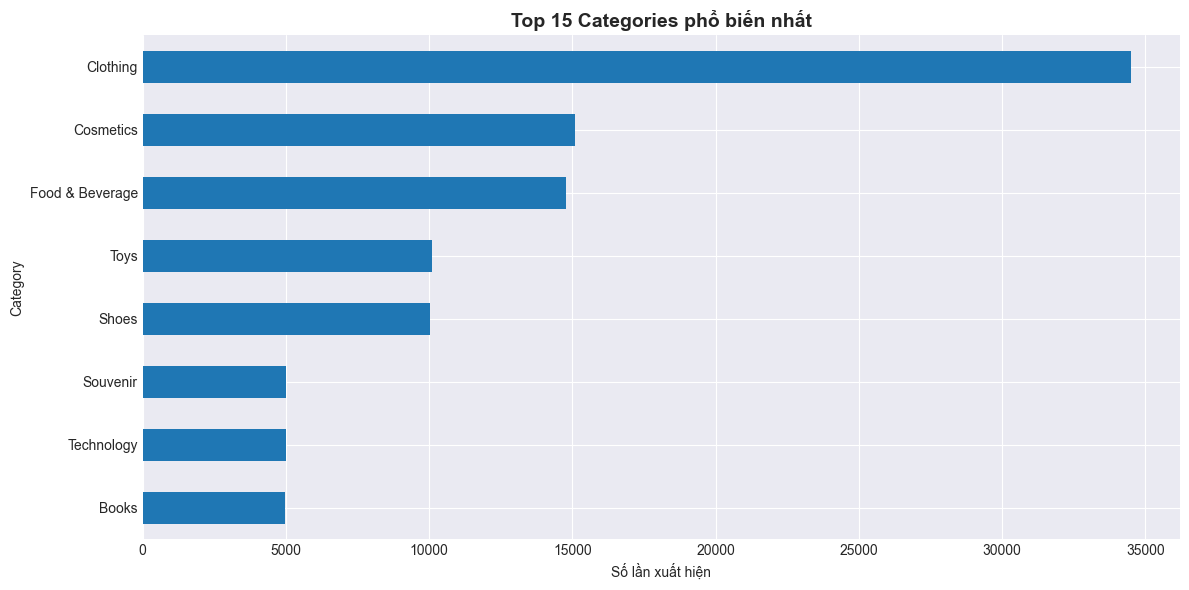


 Đã lưu: figures/01_item_frequency.png


In [17]:
print("\n[2] PHÂN TÍCH ITEM FREQUENCY:")

# Flatten all items
all_items = [item for sublist in transactions for item in sublist]
item_counts = pd.Series(all_items).value_counts()

print(f"\n  Số categories duy nhất: {len(item_counts)}")
print("\n  Top 10 categories phổ biến nhất:")
print(item_counts.head(10))
os.makedirs('figures', exist_ok=True)
# Visualize item frequency
plt.figure(figsize=(12, 6))
item_counts.head(15).plot(kind='barh')
plt.title('Top 15 Categories phổ biến nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/01_item_frequency.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Đã lưu: figures/01_item_frequency.png")


###  3.3 Chuyển đổi sang One-Hot Encoding

In [18]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"   Shape: {df_encoded.shape}")
print(f"   Sparsity: {(1 - df_encoded.sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1]))*100:.2f}%")

   Shape: (99457, 8)
   Sparsity: 87.50%
